In [1]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

# setting up the model
from sklearn import set_config
set_config(display= 'diagram')
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# xgboost
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance

# scores
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [2]:
df = pd.read_csv("data/cosmetics.csv")
df["Price"] = df["Price"].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Label        1472 non-null   object 
 1   Brand        1472 non-null   object 
 2   Name         1472 non-null   object 
 3   Price        1472 non-null   float64
 4   Rank         1472 non-null   float64
 5   Ingredients  1472 non-null   object 
 6   Combination  1472 non-null   int64  
 7   Dry          1472 non-null   int64  
 8   Normal       1472 non-null   int64  
 9   Oily         1472 non-null   int64  
 10  Sensitive    1472 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 126.6+ KB


In [3]:
df.Label.value_counts()

Moisturizer    298
Cleanser       281
Face Mask      266
Treatment      248
Eye cream      209
Sun protect    170
Name: Label, dtype: int64

In [4]:
dict_labels = {"Moisturizer": 0, "Cleanser": 1, "Face Mask": 2, "Treatment": 3, "Eye cream": 4, "Sun protect": 5}

In [5]:
df2=df.replace({"Label": dict_labels})

In [6]:
df2["Ingredients"] = df2["Ingredients"].str.split(",")
df_ingredients = df2.explode("Ingredients")
ingredients_df = df_ingredients["Ingredients"].value_counts().rename_axis('unique_values').reset_index(name='counts')
ingredients_df2 = ingredients_df.head(200)

top_ing = ingredients_df2.unique_values.to_list()
top_ing = [ele.strip(" ") for ele in top_ing]
top_ing = [("Ingredients_" + ele) for ele in top_ing]
ohe_df = pd.get_dummies(df2.explode("Ingredients")).groupby(level=0).sum()
ohe_df = ohe_df.drop(columns=[col for col in ohe_df if col not in top_ing])

In [7]:
ohe_df

,Ingredients_1,Ingredients_2-Hexanediol,Ingredients_Acrylates Copolymer,Ingredients_Acrylates/C10-30 Alkyl Acrylate Crosspolymer,Ingredients_Alcohol,Ingredients_Alcohol Denat.,Ingredients_Allantoin,Ingredients_Aloe Barbadensis Leaf Extract,Ingredients_Aloe Barbadensis Leaf Juice,Ingredients_Aluminum Hydroxide,...,Ingredients_Squalane,Ingredients_Stearyl Alcohol,Ingredients_Sucrose,Ingredients_Titanium Dioxide,Ingredients_Titanium Dioxide (CI 77891),Ingredients_Tocopherol,Ingredients_Tocopheryl Acetate,Ingredients_Trehalose,Ingredients_Triethanolamine,Ingredients_Water
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1468,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1469,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1470,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
ohe_1 = df2[["Label", "Brand", "Name", "Price", "Rank", "Combination", "Dry", "Normal", "Oily", "Sensitive"]]
ohe_1

,Label,Brand,Name,Price,Rank,Combination,Dry,Normal,Oily,Sensitive
0,0,LA MER,Crème de la Mer,175.0,4.1,1,1,1,1,1
1,0,SK-II,Facial Treatment Essence,179.0,4.1,1,1,1,1,1
2,0,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68.0,4.4,1,1,1,1,0
3,0,LA MER,The Moisturizing Soft Cream,175.0,3.8,1,1,1,1,1
4,0,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38.0,4.1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
1467,5,KORRES,Yoghurt Nourishing Fluid Veil Face Sunscreen B...,35.0,3.9,1,1,1,1,1
1468,5,KATE SOMERVILLE,Daily Deflector™ Waterlight Broad Spectrum SPF...,48.0,3.6,0,0,0,0,0
1469,5,VITA LIBERATA,Self Tan Dry Oil SPF 50,54.0,3.5,0,0,0,0,0
1470,5,ST. TROPEZ TANNING ESSENTIALS,Pro Light Self Tan Bronzing Mist,20.0,1.0,0,0,0,0,0


In [9]:
df_ohe = pd.concat([ohe_1, ohe_df], axis = 1)
df_ohe

,Label,Brand,Name,Price,Rank,Combination,Dry,Normal,Oily,Sensitive,...,Ingredients_Squalane,Ingredients_Stearyl Alcohol,Ingredients_Sucrose,Ingredients_Titanium Dioxide,Ingredients_Titanium Dioxide (CI 77891),Ingredients_Tocopherol,Ingredients_Tocopheryl Acetate,Ingredients_Trehalose,Ingredients_Triethanolamine,Ingredients_Water
0,0,LA MER,Crème de la Mer,175.0,4.1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,SK-II,Facial Treatment Essence,179.0,4.1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68.0,4.4,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,LA MER,The Moisturizing Soft Cream,175.0,3.8,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38.0,4.1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,5,KORRES,Yoghurt Nourishing Fluid Veil Face Sunscreen B...,35.0,3.9,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
1468,5,KATE SOMERVILLE,Daily Deflector™ Waterlight Broad Spectrum SPF...,48.0,3.6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1469,5,VITA LIBERATA,Self Tan Dry Oil SPF 50,54.0,3.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1470,5,ST. TROPEZ TANNING ESSENTIALS,Pro Light Self Tan Bronzing Mist,20.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
y = df_ohe["Label"]
X = df_ohe.drop(columns=["Label", "Name", "Brand"])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.5, random_state=42)

In [17]:
num_cols = ["Price", "Rank"]
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, num_cols)])

In [18]:
X_train_ct = preprocessor.fit_transform(X_train)
boost = XGBClassifier()
boost.fit(X_train_ct, y_train)
X_test_ct = preprocessor.transform(X_test)
pred_boost = boost.predict(X_test_ct)
print("train score: %.4f" % boost.score(X_train_ct, y_train))
print("test score: %.4f" % boost.score(y_test, pred_boost))

train score: 0.7758
test score: 0.2174


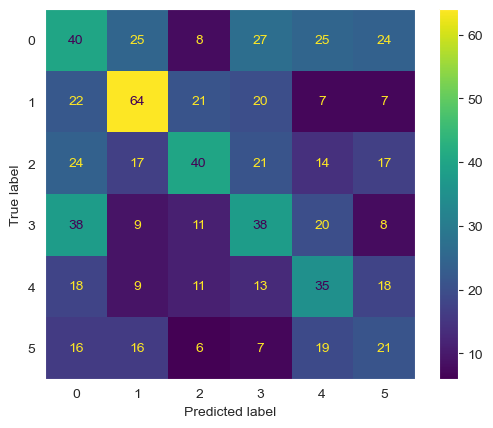

In [19]:
ConfusionMatrixDisplay.from_estimator(boost, X_test_ct, y_test)
plt.grid(False);

In [13]:
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [14]:
# lemmatize ingredients column
lemm = WordNetLemmatizer()

for i, row in df2.iterrows():
    tokens = word_tokenize(row["Ingredients"])
    lemmatized_tokens = [lemm.lemmatize(token) for token in tokens]
    df2.at[i, "Ingredients"] = " ".join(lemmatized_tokens)

df2

TypeError: expected string or bytes-like object

In [ ]:
# vectorize bagofwords column
vec = CountVectorizer(min_df = 0.06, max_df = 0.95)
X_cvec = vec.fit_transform(df2["Ingredients"])

countvec_df = pd.DataFrame(X_cvec.toarray(), columns=vec.get_feature_names_out())
countvec_df

In [ ]:
df2 = pd.concat([df2, countvec_df], axis = 1)

In [ ]:
df2 = df2.drop(columns = "Ingredients")
df2

In [ ]:
y = df2["Label"]
X = df2.drop(columns="Label")

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=42)

In [ ]:
df2_model = df2.drop(columns = ["Brand", "Name", "Price", "Rank"])

In [ ]:
y = df2_model["Label"]
X = df2_model.drop(columns="Label")

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.5, random_state=42)

In [ ]:
X_train

In [ ]:
boost = XGBClassifier()
boost.fit(X_train, y_train)
print("train score: %.4f" % boost.score(X_train, y_train))

In [ ]:
pred_boost = boost.predict(X_test)
print("XGBClassifier model recall score: %.4f" % boost.score(y_test, pred_boost))